# Correcting OCHL Metrics

Awesome! So now have a way to generate OCHL metrics to simulate candlestick charts. This is great progress, however, we do have a problem with the 'realism' of these generated values. Let's pull up and create a fresh one and see if we can catch the problem "in the act".

In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
real_p_changes = pd.read_csv('analytics/ochl_p_changes_only.csv')

real_p_changes.head()

,o_percent,c_percent,h_percent,l_percent
0,0.779403,-0.499168,1.024608,-1.304843
1,0.813102,-0.836169,1.032236,-1.009169
2,-0.655831,0.416310,0.923867,-0.684346
3,-0.272485,-0.203971,1.102929,-0.626473
4,-0.062980,-0.417955,0.938967,-0.458033


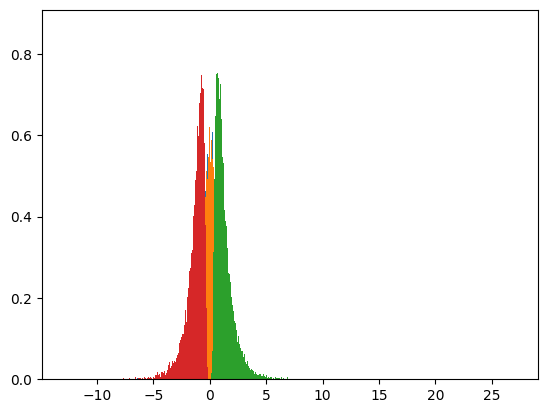

In [3]:
from data_gen import custom_sample_distribution

def extract_distributions(data):
    dist_labels = ['o_percent', 'c_percent', 'h_percent', 'l_percent']

    dist_samples = []

    for label in dist_labels:
        dist = data[label]
        x_values, x_proba = custom_sample_distribution(dist)

        dist_samples.append([x_values, x_proba])

    dist_samples = np.asarray(dist_samples)

    return dist_samples

dist_samples = extract_distributions(real_p_changes)

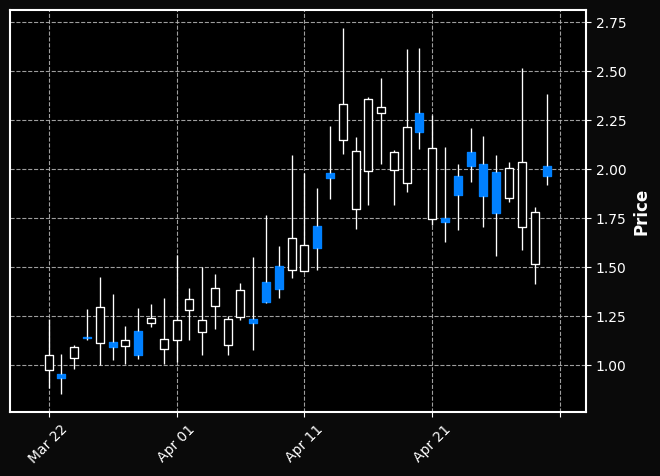

In [4]:
import mplfinance as fplt
from data_gen import generate_data

fake_data = generate_data(500, 0.15, init_val=1, ochl_dist=dist_samples, random_seed=1)
fake_data.head(10)


fake_ochl = fake_data[['Open', 'High', 'Low', 'Close']]
fplt.plot(fake_ochl[:40], type='candle', style='mike')

Ladies and gentlemen, we got him.

Look at the few days after Apr. 01, and after Apr. 11. While yes, we have the overall trends, the bodies and shadows, it isn't quite realistic at all. These movements are both sporadic, and not only sporadic, but simply ill-matching to what a real candle stick chart might look like. More often than not, if there is an upwards trend, those bodies will end up being 'green' or 'blue' in this case, meaning the market is 'bullish' in that time period (bullish being that the buyers are driving the price up). Instead, we see that the bodies are 'red' or 'black' in this case, meaning the market is 'bearish'. 

If the prices are going up in the overall trend, why would the sellers be dominating the market in each time step? And why would the opening price vary so wildly as it does in this above example?

Take a look at the following image, and pay attention to the rises and falls, and how they correlate with the candlestick's color.

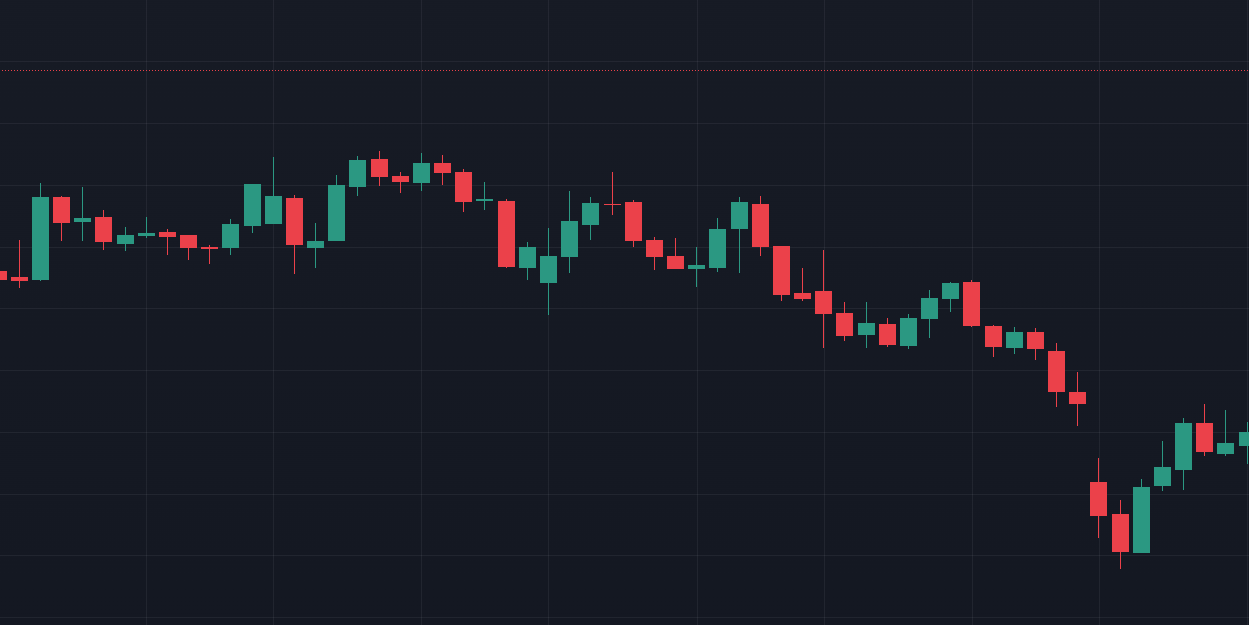

In [5]:
from IPython.display import Image
Image(filename='real_stock_example.png')

We immediately notice a few things:
- Sequences of red correlate with a consistent downtrend in price
- Sequences of green correlate with a consistent uptrend in price
- Open and close prices do not wildly differ from one another one day to the next

So in contrast with our simulations, immediately there emerges some changes to make. 

Now, are the open and close prices *always* close together? No, of course not, as there are flucuations in price in the after-market, but it is not nearly as volitile as our example is. Generally (maybe 97-99% of the time), the prices are pretty damn close to one another.

The really cool thing, is that we can actually track and understand how these things relate to one another (10 years of data for 10+ stocks really come in handy). So what exactly is it that we want to find out about the data so we can simulate this better?

- Identify Green and Red days
- Reducing Green and Red days to [1, -1] to track health of stock/company (beginnings of company specific analytics)
- Determine probabilities of:
    - Green following a Green
    - Red following a Green
    - Green following a Red
    - Red following a Red
- Calculate percentage change of previous day's close to the next day's Open or Close (dependent on if it is a red or green day that follows)
- Percentage change from an Open $\rightarrow$ Close on Green
- Percentage change from an Open $\rightarrow$ Close on Red

Further down the line (and probably in a different notebook):
- Find the relationship between OCHL metrics and daily volume
- See how the day's OCHL metric affects the probablities of the next day's color


Let's get crackin' then. Starting with the first two items on the list (the first one is already done actually, we implemented a method to do this in an earlier notebook).


## Today's Big To-Do List

### Identifying Colors and Assigning Values

In [6]:
from stock_analysis import gather_stock_data
from stock_analysis import identify_candle_color
import os

data_folder = 'data'
filenames = os.listdir(data_folder)

stock_data = gather_stock_data(filenames, concat=True)
stock_data = identify_candle_color(stock_data)

stock_data.head()

,Label,Date,Volume,Close/Last,Open,High,Low,Color
0,AAPL,09/30/2013,259059760.0,17.0268,17.0446,17.2021,16.9433,r
1,AAPL,10/01/2013,352776899.0,17.4271,17.0875,17.4693,17.0850,g
2,AAPL,10/02/2013,287196445.0,17.4843,17.3439,17.5643,17.2768,g
3,AAPL,10/03/2013,315209314.0,17.2646,17.5182,17.5839,17.1692,r
4,AAPL,10/04/2013,258552177.0,17.2511,17.2807,17.3071,17.0929,r


In [7]:
def binary_indicator(data):
    data['binary_indicator'] = np.where(data['Color'] == 'g', 1, -1)

    return data

stock_data = binary_indicator(stock_data)
stock_data.head()

,Label,Date,Volume,Close/Last,Open,High,Low,Color,binary_indicator
0,AAPL,09/30/2013,259059760.0,17.0268,17.0446,17.2021,16.9433,r,-1
1,AAPL,10/01/2013,352776899.0,17.4271,17.0875,17.4693,17.0850,g,1
2,AAPL,10/02/2013,287196445.0,17.4843,17.3439,17.5643,17.2768,g,1
3,AAPL,10/03/2013,315209314.0,17.2646,17.5182,17.5839,17.1692,r,-1
4,AAPL,10/04/2013,258552177.0,17.2511,17.2807,17.3071,17.0929,r,-1


That was easy and straightforward, and although we might not use this information right away, it will come in handy in the future. For curiosity's sake, let's do a quick aggregation.

In [8]:
stock_data['binary_indicator'].sum()

904

This alone is an interesting thing to see. It means that over 10 years of data for 10 stocks, the overall trend is strongly positive (considering the stocks we are working with, this should come as no surprise).

In [9]:
stock_data[stock_data['Label'] == 'TSLA']

,Label,Date,Volume,Close/Last,Open,High,Low,Color,binary_indicator
37774,TSLA,10/09/2013,229518185.0,11.2520,11.6487,11.6660,10.7667,r,-1
37775,TSLA,10/10/2013,132549174.0,11.5287,11.5393,11.7167,11.3127,r,-1
37776,TSLA,10/11/2013,124441933.0,11.9133,11.5167,11.9525,11.4133,g,1
37777,TSLA,10/14/2013,116359112.0,11.9813,11.6667,12.1667,11.6100,g,1
37778,TSLA,10/15/2013,164328668.0,12.2627,12.3520,12.5859,12.2120,r,-1
...,...,...,...,...,...,...,...,...,...
40285,TSLA,10/02/2023,123810400.0,251.6000,244.8100,254.2799,242.6200,g,1
40286,TSLA,10/03/2023,101985300.0,246.5300,248.6100,250.0200,244.4500,r,-1
40287,TSLA,10/04/2023,129721600.0,261.1600,248.1400,261.8600,247.6000,g,1
40288,TSLA,10/05/2023,119159200.0,260.0500,260.0000,263.6000,256.2500,g,1


In [10]:
stock_health = stock_data.groupby('Label').sum()
stock_health_by_label = stock_health['binary_indicator']
stock_health_by_label

Label
AAPL    160
ACU     -82
ADBE    216
AMD    -112
AMZN    -30
BA      -14
C        40
CSCO    146
JNJ      54
JPM       0
META     78
MSFT    136
NFLX    -40
PG      108
QCOM     96
SBUX     54
TSLA      0
V       108
WMT      44
XOM     -58
Name: binary_indicator, dtype: int32

Here we get to see a better picture of each stock in relation to each other. We see that over the course of 10 years, some companies have been doing far better than other companies.


Next on the list is determining probablities of one color following another color. We're going to do that by stepping through each datapoint and simplying incrementing counters based on what color follows what, and then from there taking these summations and dividing them by the total number of green or red days.

Something like, if we have 5 green and 5 red, in this fashion: $x = [g, ~r, ~r, ~g, ~g, ~r, ~g, ~r, ~r, ~g]$

Then we sum into 4 buckets based on the starting color and the following color, $gg, gr, rg, rr$, leading us to this result:
$$
\begin{equation} \begin{aligned}
gg &= 1 \\
gr &= 3 \\
rg &= 3 \\
rr &= 2 \\
\end{aligned}\end{equation}
$$

Now, this doesn't add up to $10$, but that is fine, because we have $9$ pairs to work with. So our probabilities would end up as:

$$
\begin{equation} \begin{aligned}
gg ~&= 1/9 &= 0.1111 \\
gr ~&= 3/9 &= 0.3333 \\
rg ~&= 3/9 &= 0.3333 \\
rr ~&= 2/9 &= 0.2222 \\
\end{aligned}\end{equation}
$$

Which rougly adds up to 1.

The implementation follows:

In [11]:
def color_probabilities(data):
    colors = data['Color']
    
    numPairs = len(data) - 1
    gg, gr = 0, 0
    rg, rr = 0, 0

    for x in range(len(data)-1):
        if colors[x] == 'g':
            if colors[x+1] == 'g': gg += 1
            else: gr += 1
        elif colors[x] == 'r':
            if colors[x+1] == 'g': rg += 1
            else: rr += 1

    counts = [gg, gr, rg, rr]
    probabilities = []


    for sum in counts:
        probabilities.append(sum / numPairs)

    return probabilities

color_probs = color_probabilities(stock_data)
color_probs

print('Green following a green : ', color_probs[0])
print('Red following a green   : ', color_probs[1])
print('Green following a red   : ', color_probs[2])
print('Red following a red     : ', color_probs[3])

Green following a green :  0.25378843299960285
Red following a green   :  0.25564868423802856
Green following a red   :  0.2556695859373367
Red following a red     :  0.23489329682503188


Well, this is a tad bit unfortunate and/or upsetting. It does however, confirm the idea that the color of a stock is mostly random, and there there isn't much to do in predicting a subsequent color based off the color alone (this is why we want to factor in the OCHL metrics as well).

For fun, why don't we increase the overall size of our datase, just for a more robust analysis (it probably won't make much of a difference, but we also will want to not only start collecting more data to work with, but also start thinking about working with datasets of different sizes in conjunction with one another). These changes won't be apparent in the notebook, due to the fact that I will simply refresh the whole notebook and regenerate all the analytics with the new data, but this note will be left in for historical purposes.


#### Update
And with more data, it even more reinforces the fact that it is roughly random purely based on color alone.


## Continuation of the To-Do List

Here are the remaining items on the list:
- Calculate percentage change of previous day's close to the next day's Open or Close (dependent on if it is a red or green day that follows)
- Percentage change from an Open $\rightarrow$ Close on Green
- Percentage change from an Open $\rightarrow$ Close on Red

So, now we are going to work on the first item. The reasoning for aquiring this distribution is for more realistic simulation in our fake datasets. If we look at real stock data's price 'flow', we notice that often the previous day's close is often close to the next day's open/close based on the color of the previous day's. If we aquire that information, using the random probabilities we gathered using the data above on color following, we can figure out what a reasonable following open/close might look like.

Reproducing the image of real stock prices from above:

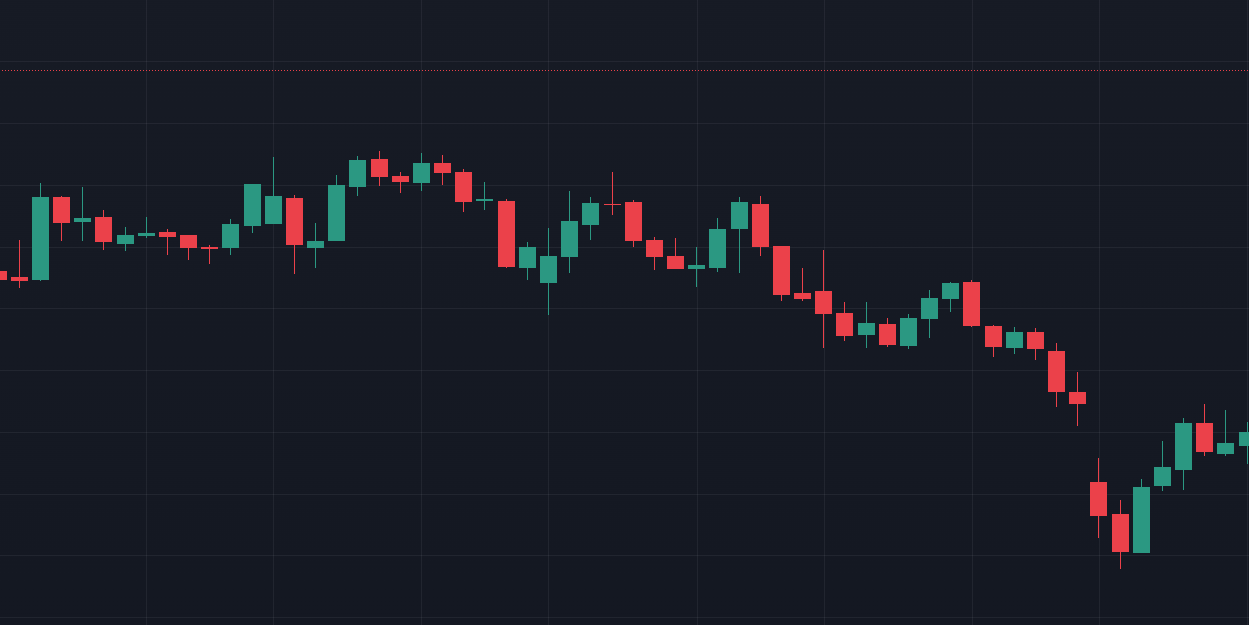

In [12]:
Image(filename='real_stock_example.png')

Of course, there are many days where the price starts above or below the previous day's close, as in, it is not a 1-to-1, but that is ok. I am willing to bet that will get ironed out and/or captured in the distribution we generate.

Although there are cases where a day's open may be lower or higher than the previous' close, there is often the trend of consistent 'steps' in either the positive or negative direction.

The following two items on the task list further furnish our ability to simulate the data, and not only this, but it will consistently be either positive or negative given the color of the day (because a green day is always an increase, and a red day is always a decrease).

Let's take a crack at it and see how it pans out:

### Percentage Changes from Previous Day to Next's Open/Close
- Calculate percentage change of previous day's close to the next day's Open or Close (dependent on if it is a red or green day that follows)

In [13]:
def calculate_percentage_change(val1, val2):
    change = (val2 - val1) / val1 * 100

    return change

# Update

Upon reflection, and a bit of confusion (I don't know why I decided what I decided), I realized that I should be tracking changes from the previous day's close to the next day's open. Not a close to the following's open or closed based on color. It just doesn't make any sense to do it like that, and I do not remember why I decided to approach the problem like that.

As I look through the previous code cells, I believe it was a slight leftover from working with color sequences. I am going to retain the previous implementation purely for documentation purposes.

In [14]:
# This is no longer the implementation and/or solution I will be pursuing
def percent_change_between_days_inefficient(data):
    changes = []
    
    for x in range(len(data)-1):
        curr_day = data.loc[x, :]
        next_day = data.loc[x+1, :]

        curr_close = curr_day['Close/Last']
        

        if next_day['Color'] == 'g':
            next_val = next_day['Open']
        else:
            next_val = next_day['Close/Last']

        change = calculate_percentage_change(curr_close, next_val)

        changes.append(change)

    changes.append(0)
    data['close_to_next_change'] = changes


    return data

# stock_data_temp = percent_change_between_days_inefficient(stock_data)

# stock_data_temp.head()

In [15]:
def percent_change_between_days_depreciated(data):
    changes = []
    next_color = []
    
    for x in range(len(data)-1):
        curr_close = data.loc[x, 'Close/Last']

        if data.loc[x+1, 'Color'] == 'g':
            next_val = data.loc[x+1, 'Open']
            next_color.append('g')
        else:
            next_val = data.loc[x+1, 'Close/Last']
            next_color.append('r')

        change = calculate_percentage_change(curr_close, next_val)

        changes.append(change)

    changes.append(0)
    next_color.append(next_color[-1])

    data['close_to_next_change'] = changes
    data['next_color'] = next_color


    return data

# stock_data_temp = percent_change_between_days_depreciated(stock_data)
# stock_day_changes = stock_data_temp[['Color', 'close_to_next_change', 'next_color']]

# stock_day_changes.head()

I'm keeping the two versions above to illustrate a neat discovery. The second version is far more efficient because of how we are accessing the DataFrame. So we will continue to keep using this method of dataframe accesssing in comparison to the initial method. If you look at the second function, you see that I also track the next day's color in the 'current' days row. This is for easier subsetting.

I'm also going to subsection this information based on the 4 color permutations we explored later. This way we can really get a sense of how these things change in flux.


---

It looks like I also decided to track which color follows, and that much might be still useful, if we use that to subset off of. That way we still have the separation between distributions that contain $c = [gg, gr, rg, rr]$. That is, *if there is any impact on the prev. close $\rightarrow$ next open prices, we will be able to capture that, and not only capture it, but make use of it. Otherwise, we are still going tracking just prev. close $\rightarrow$ next open percentage changes. That much will hopefully streamline our implementation.

As per update, the new method:

In [16]:
def percent_change_between_days(data):
    changes = []
    next_color = []
    
    for x in range(len(data)-1):
        curr_close = data.loc[x, 'Close/Last']
        next_open = data.loc[x+1, 'Open']
        
        if data.loc[x+1, 'Color'] == 'g':    
            next_color.append('g')
        else:
            next_color.append('r')

        change = calculate_percentage_change(curr_close, next_open)
        changes.append(change)

    changes.append(0)
    next_color.append(next_color[-1])

    data['clost_to_next_open'] = changes
    data['next_color'] = next_color


    return data

stock_data_temp = percent_change_between_days(stock_data)
stock_day_changes = stock_data_temp[['Color', 'clost_to_next_open', 'next_color']]

stock_day_changes.head()

,Color,clost_to_next_open,next_color
0,r,0.356497,g
1,g,-0.477417,g
2,g,0.193888,r
3,r,0.093254,r
4,r,0.730388,g


In [17]:
colors = ['g', 'r']

green_days = stock_day_changes[stock_day_changes['Color'] == 'g']
red_days = stock_day_changes[stock_day_changes['Color'] == 'r']

gg = green_days[green_days['next_color'] == 'g']['clost_to_next_open']
gr = green_days[green_days['next_color'] == 'r']['clost_to_next_open']
rg = red_days[red_days['next_color'] == 'g']['clost_to_next_open']
rr = red_days[red_days['next_color'] == 'r']['clost_to_next_open']

follow_dists = [gg, gr, rg, rr]

print('gg', gg.describe())
print('\ngr', gr.describe())
print('\nrg', rg.describe())
print('\nrr', rr.describe())

gg count    12143.000000
mean        -0.015669
std          1.877568
min        -81.732430
25%         -0.400119
50%          0.023542
75%          0.448226
max         21.318922
Name: clost_to_next_open, dtype: float64

gr count    12231.000000
mean         0.036958
std          2.194074
min        -89.515899
25%         -0.332344
50%          0.058789
75%          0.476380
max         18.876107
Name: clost_to_next_open, dtype: float64

rg count    12232.000000
mean         0.036538
std          2.117284
min        -91.310215
25%         -0.411157
50%          0.046956
75%          0.496317
max        114.409848
Name: clost_to_next_open, dtype: float64

rr count    11238.000000
mean         0.041231
std          1.971299
min        -99.316641
25%         -0.349666
50%          0.075253
75%          0.492663
max         20.077564
Name: clost_to_next_open, dtype: float64


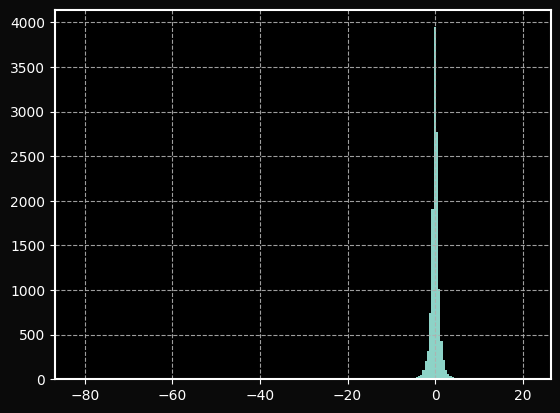

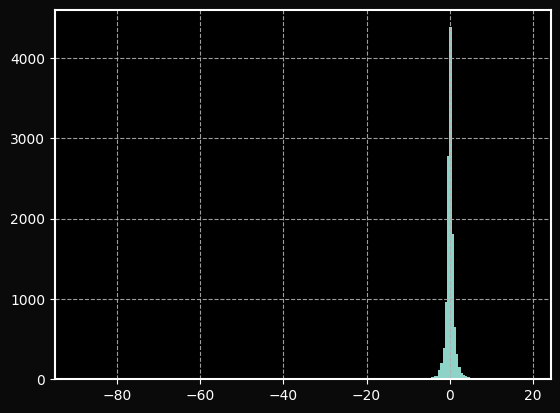

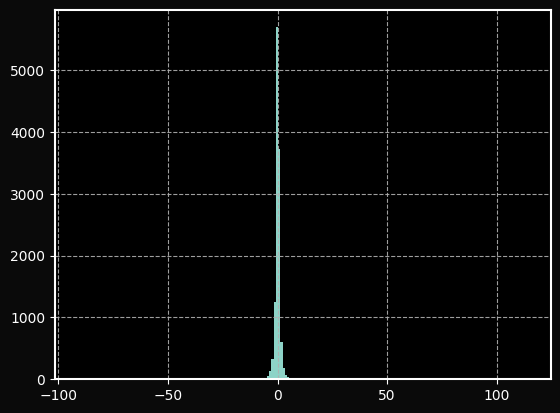

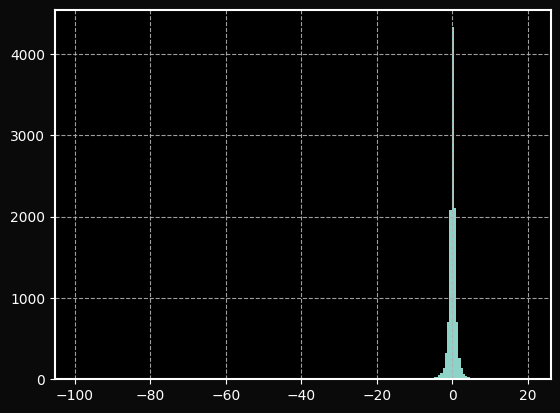

In [18]:
for dist in follow_dists:
    plt.hist(dist, bins=200)
    plt.show()

It's pretty clear by the above histogram plots that there are 'outliers'. I am... mixed on how to approach these datapoints, whether to keep them or remove them. For the momenet, I think I will keep them, because it simply 'is' the data, and the probability that one of those outliers are going to be picked are pretty low in comparision to the other values (which hover very tightly to 0). Perhaps it is worth keeping them, as the market sometimes does have those kinds of surprises.

## Percentage Change from Open $\rightarrow$ Close
- Percentage change from an Open $\rightarrow$ Close on Green
- Percentage change from an Open $\rightarrow$ Close on Red

These last two items are a lot easier to get done, luckily, and in fact (even luckier), we can perform these calculations in one step

In [19]:
def percent_change_open_close_on_color(data):
    data['change_open_close'] = calculate_percentage_change(data['Open'], data['Close/Last'])

    return data

stock_data = percent_change_open_close_on_color(stock_data)

stock_data.head()

,Label,Date,Volume,Close/Last,Open,High,Low,Color,binary_indicator,clost_to_next_open,next_color,change_open_close
0,AAPL,09/30/2013,259059760.0,17.0268,17.0446,17.2021,16.9433,r,-1,0.356497,g,-0.104432
1,AAPL,10/01/2013,352776899.0,17.4271,17.0875,17.4693,17.0850,g,1,-0.477417,g,1.987418
2,AAPL,10/02/2013,287196445.0,17.4843,17.3439,17.5643,17.2768,g,1,0.193888,r,0.809507
3,AAPL,10/03/2013,315209314.0,17.2646,17.5182,17.5839,17.1692,r,-1,0.093254,r,-1.447637
4,AAPL,10/04/2013,258552177.0,17.2511,17.2807,17.3071,17.0929,r,-1,0.730388,g,-0.171289


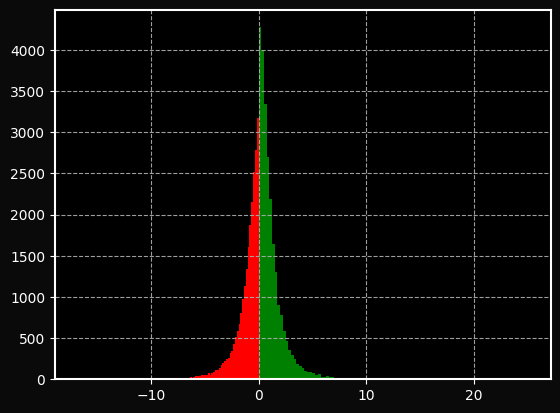

In [20]:
green_o_c_changes = stock_data[stock_data['Color'] == 'g']['change_open_close']
red_days_o_c_changes = stock_data[stock_data['Color'] == 'r']['change_open_close']

plt.hist(green_o_c_changes, bins=100, color='g')
plt.hist(red_days_o_c_changes, bins=100, color='r')
plt.show()


Since we are essentially recreating our percentage change distributions, we probably ought to recalculate our high and lows as well, but instead of generating off of a global average, base it on the open and close values given the day's color.

We want this information specifically, because when we rebuild our stock_generator, we are going to be randomly picking the next day's color, pick the new open/close based on the color sequence, and then fill in the rest of the information relative to that new initial value. If we have the high and lows in a color dependent format, then we can generate new information in the described fashion.

So, to gather the high and low information (again):

In [21]:
def percent_high_low(data):
    
    for x in range(len(data)):
        curr_day = data.loc[x, :]

        if curr_day['Color'] == 'g':
            data.loc[x, 'high_change'] = calculate_percentage_change(curr_day['Close/Last'], curr_day['High'])
            data.loc[x, 'low_change'] = calculate_percentage_change(curr_day['Open'], curr_day['Low'])
        else:
            data.loc[x, 'high_change'] = calculate_percentage_change(curr_day['Open'], curr_day['High'])
            data.loc[x, 'low_change'] = calculate_percentage_change(curr_day['Close/Last'], curr_day['Low'])

    return data

stock_data = percent_high_low(stock_data)

stock_data.head()


,Label,Date,Volume,Close/Last,Open,High,Low,Color,binary_indicator,clost_to_next_open,next_color,change_open_close,high_change,low_change
0,AAPL,09/30/2013,259059760.0,17.0268,17.0446,17.2021,16.9433,r,-1,0.356497,g,-0.104432,0.924046,-0.490403
1,AAPL,10/01/2013,352776899.0,17.4271,17.0875,17.4693,17.0850,g,1,-0.477417,g,1.987418,0.242152,-0.014631
2,AAPL,10/02/2013,287196445.0,17.4843,17.3439,17.5643,17.2768,g,1,0.193888,r,0.809507,0.457553,-0.386880
3,AAPL,10/03/2013,315209314.0,17.2646,17.5182,17.5839,17.1692,r,-1,0.093254,r,-1.447637,0.375039,-0.552576
4,AAPL,10/04/2013,258552177.0,17.2511,17.2807,17.3071,17.0929,r,-1,0.730388,g,-0.171289,0.152772,-0.917043


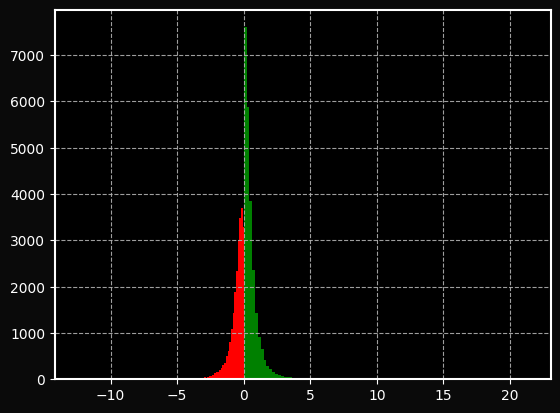

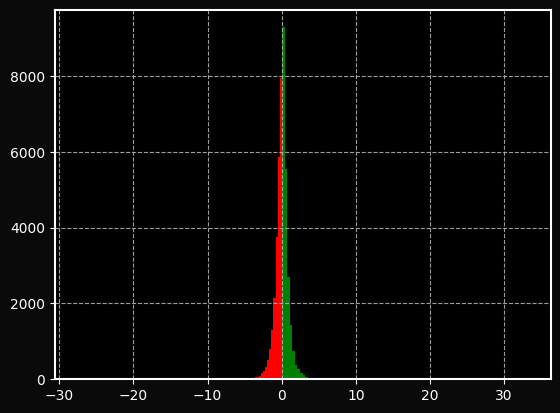

In [22]:
green_days = stock_data[stock_data['Color'] == 'g'][['high_change', 'low_change']]
red_days = stock_data[stock_data['Color'] == 'r'][['high_change', 'low_change']]

plt.hist(green_days['high_change'], bins=100, color='g')
plt.hist(green_days['low_change'], bins=100, color='r')
plt.show()

plt.hist(red_days['high_change'], bins=100, color='g')
plt.hist(red_days['low_change'], bins=100, color='r')
plt.show()


In [23]:
columns_to_save = ['Color', 'next_color', 'clost_to_next_open','change_open_close', 'high_change', 'low_change']

stock_data[columns_to_save].head()

candlestick_metrics = stock_data[columns_to_save]

In [24]:
candlestick_metrics.to_csv('analytics/candlestick_metrics.csv', index=False)